# Load Forecasting SPP Data

# Load the data from the SPP dataset, clean it, and perform some basic data exploration.

* There are 85 missing dates in the dataset. The biggest impact is within the following date ranges:
  * 2023-07-22 ~ 2023-09-17 (58 missing dates)
  * 2024-01-01 ~ 2024-02-20 (23 missing dates)
* Missing hourly values are imputed using linear interpolation.
* Daylight savings time is not accounted for in the training data. I remove the hour that is repeated in the fall.

In [35]:
import datetime
import glob

import pandas as pd

from adhoc_energy_analytics.constants import RAW_DATA_DIR

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 200)

datetime_cols = [
    "UTC Timestamp (Interval Ending)",
    "Local Timestamp Central Time (Interval Beginning)",
    "Local Timestamp Central Time (Interval Ending)",
    "Local Date",
]

In [2]:
# Get a list of all files matching the pattern
df_file_list = glob.glob(f"{RAW_DATA_DIR}/spp_load-temp_hr_*")

# Read all files into a single dataframe
df_list = [
    pd.read_csv(file, skiprows=3, parse_dates=datetime_cols) for file in df_file_list
]
df = pd.concat(df_list, ignore_index=True)

# Trim spaces from column names
df.columns = df.columns.str.strip()

# Set index to datetime
df.set_index("Local Timestamp Central Time (Interval Beginning)", inplace=True)

# Drop index duplicates (daylight savings)
df = df[~df.index.duplicated(keep="first")]

# Create a new index starting from the minimum date and ending at the maximum date
new_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq="H")

# Reindex the dataframe
df = df.reindex(new_index)

# Remove all dates where there is no local data for all 24 hours
null_hourly_value_counts = (
    df[df["KCPL Actual Load (MW)"].isna()].index.normalize().value_counts(sort=False)
)
null_dates = null_hourly_value_counts[null_hourly_value_counts == 24].index.to_numpy()
df = df[~df.index.normalize().isin(null_dates)]

# Fill missing values with linear interpolation
columns_to_fill = [
    "SPP Total Forecast Load (MW)",
    "SPP Total Actual Load (MW)",
    "CSWS Actual Load (MW)",
    "EDE Actual Load (MW)",
    "GRDA Actual Load (MW)",
    "INDN Actual Load (MW)",
    "KACY Actual Load (MW)",
    "KCPL Actual Load (MW)",
    "LES Actual Load (MW)",
    "MPS Actual Load (MW)",
    "NPPD Actual Load (MW)",
    "OKGE Actual Load (MW)",
    "OPPD Actual Load (MW)",
    "SECI Actual Load (MW)",
    "SPRM Actual Load (MW)",
    "SPS Actual Load (MW)",
    "WAUE Actual Load (MW)",
    "WFEC Actual Load (MW)",
    "WR Actual Load (MW)",
    "Kansas City International Airport Temperature (Fahrenheit)",
    "Oklahoma City Temperature (Fahrenheit)",
]
df[columns_to_fill] = df[columns_to_fill].interpolate(
    method="linear", limit_direction="both"
)

/var/folders/1p/ngsbv_gj3px52qmhqchv10j00000gn/T/ipykernel_66500/3084207830.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  new_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq="H")


### How many years of data do we have?

In [3]:
# Extract the unique years from the 'UTC Timestamp (Interval Ending)' column
years = df.index.year.unique()

# Calculate the number of unique years
num_years = len(years)
print(f"We have {num_years} years of data.")

We have 5 years of data.


### Which demand regions are available?

* CSWS – Public Service Company of Oklahoma (PSO) / Southwestern Electric Power Company (SWEPCO) (Part of AEP - American Electric Power)
* EDE – Empire District Electric Company
* GRDA – Grand River Dam Authority (Oklahoma)
* INDN – City of Independence, Missouri (Independence Power & Light)
* KACY – Kansas City Board of Public Utilities (Kansas City, KS)
* KCPL – Kansas City Power & Light (Now Evergy)
* LES – Lincoln Electric System (Nebraska)
* MPS – Missouri Public Service (Now part of Evergy)
* NPPD – Nebraska Public Power District
* OKGE – Oklahoma Gas & Electric (OG&E)
* OPPD – Omaha Public Power District (Nebraska)
* SECI – Sunflower Electric Cooperative, Inc. (Kansas)
* SPRM – Springfield, Missouri City Utilities
* SPS – Southwestern Public Service Company (Xcel Energy - serving parts of Texas, New Mexico, Oklahoma, and Kansas)
* WAUE – Western Area Power Administration, Upper Great Plains (WAPA-UGP)
* WFEC – Western Farmers Electric Cooperative (Oklahoma & surrounding states)
* WR – Westar Energy (now part of Evergy)

In [4]:
# Extract columns that contain 'Actual Load (MW)'
load_columns = [col for col in df.columns if "Actual Load (MW)" in col]

# Print the locations
locations = [col.strip().split(" ")[0] for col in load_columns]
print("Tracked locations:", locations)

Tracked locations: ['SPP', 'CSWS', 'EDE', 'GRDA', 'INDN', 'KACY', 'KCPL', 'LES', 'MPS', 'NPPD', 'OKGE', 'OPPD', 'SECI', 'SPRM', 'SPS', 'WAUE', 'WFEC', 'WR']


### What does the load for KCPL look like over the past 2 weeks?

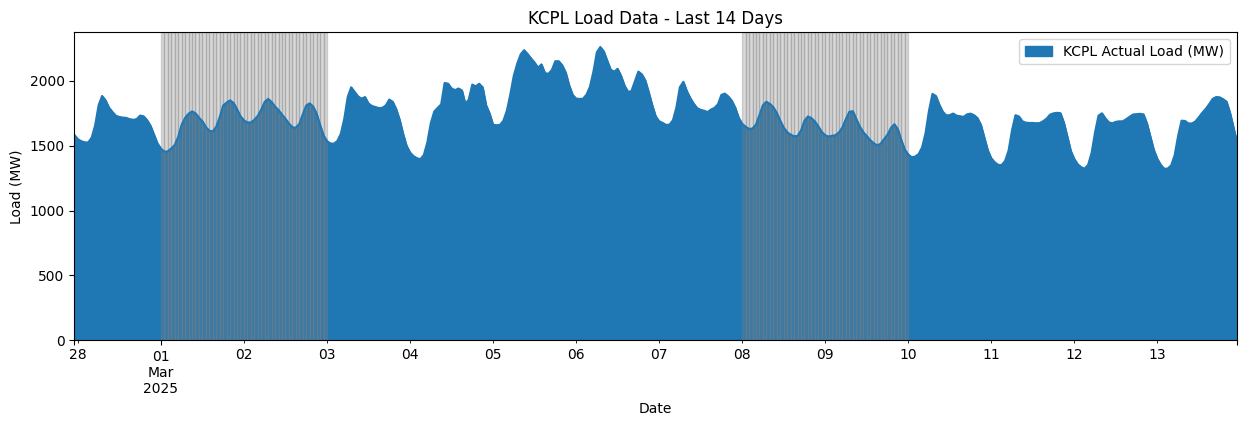

In [5]:
import matplotlib.pyplot as plt

# Filter the dataframe for the last 14 days
recent_14_days = df[df.index >= (df.index.max() - pd.Timedelta(days=14))]

# Select the relevant columns
kcpl_recent_14_days = recent_14_days[["KCPL Actual Load (MW)"]]

# Plot the data as an area chart with increased width
ax = kcpl_recent_14_days.plot(
    y="KCPL Actual Load (MW)",
    kind="area",
    title="KCPL Load Data - Last 14 Days",
    figsize=(15, 4),
)

# Highlight weekends
for index, row in kcpl_recent_14_days.iterrows():
    # 5 = Saturday, 6 = Sunday
    if row.name.weekday() >= 5:
        ax.axvspan(
            row.name,
            row.name + pd.Timedelta(hours=1),
            color="gray",
            alpha=0.3,
        )

plt.xlabel("Date")
plt.ylabel("Load (MW)")
plt.show()

### How does the load differ between weekdays and weekends?

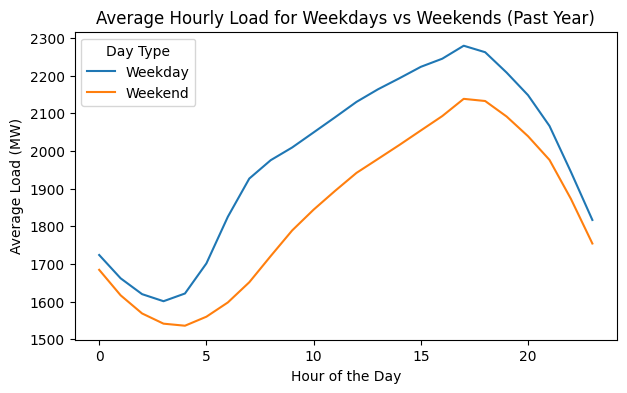

In [6]:
# Filter the dataframe for the past year
past_year = df[df.index >= (df.index.max() - pd.DateOffset(years=1))].copy()

# Create 'Day Type' column
past_year["Day Type"] = past_year.index.dayofweek.map(
    lambda x: "Weekend" if x >= 5 else "Weekday"
)

# Group the data by 'Hour Number' and 'Day Type' and calculate the mean load
average_hourly_load = (
    past_year.groupby([past_year.index.hour, "Day Type"])["KCPL Actual Load (MW)"]
    .mean()
    .unstack()
)

# Plot the average hourly load for weekdays and weekends
average_hourly_load.plot(
    kind="line",
    figsize=(7, 4),
    title="Average Hourly Load for Weekdays vs Weekends (Past Year)",
)
plt.xlabel("Hour of the Day")
plt.ylabel("Average Load (MW)")
plt.show()

In [7]:
# Calculate the average load for weekdays and weekends
average_load = past_year.groupby("Day Type")["KCPL Actual Load (MW)"].mean()

# Print the results
print("Average Load (MW):")
print(average_load)

# Calculate the absolute difference
absolute_difference = average_load["Weekday"] - average_load["Weekend"]
print(f"\nAbsolute Difference (MW): {absolute_difference:.2f}")

# Calculate the percentage difference
percentage_difference = (absolute_difference / average_load["Weekend"]) * 100
print(f"Percentage Difference: {percentage_difference:.2f}%")

# Determine which day type has higher load
if average_load["Weekday"] > average_load["Weekend"]:
    print("\nLoad is higher on weekdays.")
else:
    print("\nLoad is higher on weekends.")

Average Load (MW):
Day Type
Weekday    1978.424918
Weekend    1837.061472
Name: KCPL Actual Load (MW), dtype: float64

Absolute Difference (MW): 141.36
Percentage Difference: 7.70%

Load is higher on weekdays.


### How about seasonality?

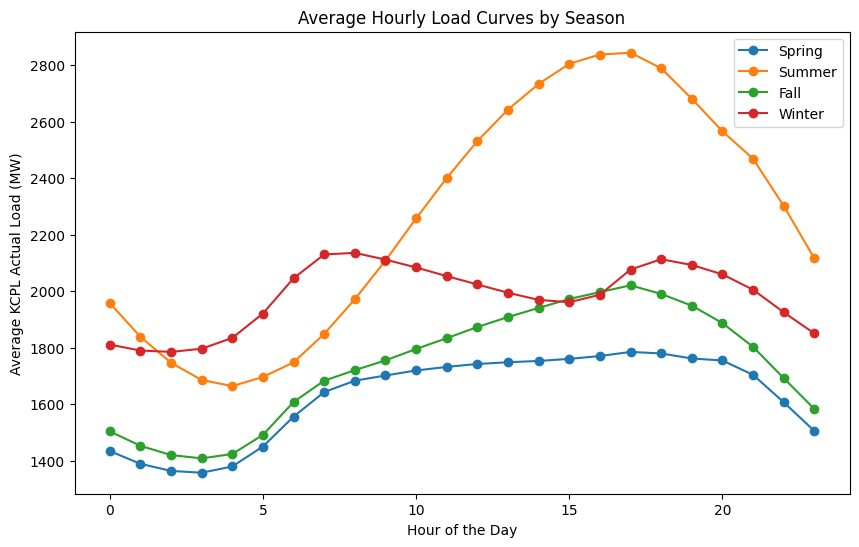

In [8]:
# Create a mapping from month to season
def month_to_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"


# Create a 'Season' column in df using the 'Local Date' column
df["Season"] = df.index.month.map(month_to_season)

# Group by season and hour to compute average load for KCPL
avg_hourly_load = (
    df.groupby(["Season", df.index.hour.rename("Hour Number")])["KCPL Actual Load (MW)"]
    .mean()
    .reset_index()
)

# Plot the load curves for each season
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for season in ["Spring", "Summer", "Fall", "Winter"]:
    season_data = avg_hourly_load[avg_hourly_load["Season"] == season]
    plt.plot(
        season_data["Hour Number"],
        season_data["KCPL Actual Load (MW)"],
        marker="o",
        label=season,
    )

plt.xlabel("Hour of the Day")
plt.ylabel("Average KCPL Actual Load (MW)")
plt.title("Average Hourly Load Curves by Season")
plt.legend()
plt.show()

### How strongly is the KCPL load correlated with the temperature measured at MCI?

In [16]:
# Select relevant columns for correlation
correlation_data = df[
    [
        "KCPL Actual Load (MW)",
        "Kansas City International Airport Temperature (Fahrenheit)",
    ]
]

# Drop rows with missing values
correlation_data.dropna(inplace=True)

# Calculate correlation matrix
correlation_matrix = correlation_data.corr()

# Extract the correlation of load with each temperature column
load_temp_correlation = correlation_matrix["KCPL Actual Load (MW)"][
    ["Kansas City International Airport Temperature (Fahrenheit)"]
]

print("Correlation of KCPL Actual Load (MW) with Temperature:")
print(load_temp_correlation)

Correlation of KCPL Actual Load (MW) with Temperature:
Kansas City International Airport Temperature (Fahrenheit)    0.212918
Name: KCPL Actual Load (MW), dtype: float64


/var/folders/1p/ngsbv_gj3px52qmhqchv10j00000gn/T/ipykernel_66500/829764373.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correlation_data.dropna(inplace=True)


In [10]:
# Calculate the sum of daily temperature and sum of daily load
daily_sum = (
    df.groupby(df.index.date)
    .agg(
        daily_temp_avg=(
            "Kansas City International Airport Temperature (Fahrenheit)",
            "mean",
        ),
        daily_load_sum=("KCPL Actual Load (MW)", "sum"),
    )
    .reset_index()
)

# Calculate the correlation between daily temperature sum and daily load sum
correlation = daily_sum["daily_temp_avg"].corr(daily_sum["daily_load_sum"])

print("Correlation between daily temperature sum and daily load sum:", correlation)

Correlation between daily temperature sum and daily load sum: 0.1412565220301884


# Modeling

## Create test and train datasets

* Fixed-size rolling window → Each training set has the same number of historical days.
* 1-day gap between training and test sets → Mimics real-world forecasting constraints.
* Test sets start at 00:00 and last exactly 24 hours
* Randomly distributed test days → Avoids bias from sequential selection.
* No overlap between test sets → Ensures independent evaluations.

In [ ]:
import random

import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler


def smape(y_true, y_pred):
    """
    Compute Symmetric Mean Absolute Percentage Error (sMAPE)
    """
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    smape_value = np.mean(np.abs(y_true - y_pred) / denominator) * 100
    return smape_value


# Define features and target
features = [
    "Year",
    "Month",
    "Day",
    "Hour",
    "Weekday",
    "Weekend",
    "Season",
    "Kansas City International Airport Temperature (Fahrenheit)",
]
target = "KCPL Actual Load (MW)"

# Prepare the feature matrix and target vector
X = df.assign(
    Year=df.index.year,
    Month=df.index.month,
    Day=df.index.day,
    Hour=df.index.hour,
    Weekday=df.index.weekday,
    Weekend=(df.index.weekday >= 5),
)[features]
y = df["KCPL Actual Load (MW)"]

# Extract unique full days from the DatetimeIndex
valid_dates = df.index.normalize().unique()

# Define parameters
n_splits = 9  # Number of cross-validation splits
train_days = 365 * 2  # Fixed training window size (e.g., 2 years)
gap_days = 1  # One-day gap between training and testing
test_days = 1  # Always 1 day (24-hour test window)

valid_test_days = [
    date
    for date in valid_dates
    if (date - pd.Timedelta(days=train_days + gap_days)) in valid_dates
]

# Randomly select test days from valid ones
random_test_days = sorted(
    random.sample(valid_test_days, min(n_splits, len(valid_test_days)))
)

# Store custom time-based splits
custom_splits = []

for test_day in random_test_days:
    # Define test indices (24-hour period starting at 00:00)
    test_mask = (df.index >= test_day) & (
        df.index < test_day + pd.Timedelta(days=test_days)
    )
    test_indices = df.index[test_mask]

    # Define training indices (fixed-size window before the gap day)
    train_start = test_day - pd.Timedelta(days=train_days + gap_days)
    train_end = test_day - pd.Timedelta(days=gap_days)
    train_mask = (df.index >= train_start) & (df.index < train_end)
    train_indices = df.index[train_mask]

    # Store the train-test split
    if len(test_indices) == 24 and len(train_indices) > 0:  # Ensure valid splits
        print(f"Train period: {train_indices.min()} to {train_indices.max()}")
        print(f"Test period: {test_indices.min()} to {test_indices.max()}")
        print()
        custom_splits.append((train_indices.tolist(), test_indices.tolist()))

Train period: 2021-03-17 00:00:00 to 2023-03-16 23:00:00
Test period: 2023-03-18 00:00:00 to 2023-03-18 23:00:00

Train period: 2021-06-02 00:00:00 to 2023-06-01 23:00:00
Test period: 2023-06-03 00:00:00 to 2023-06-03 23:00:00

Train period: 2021-12-15 00:00:00 to 2023-12-14 23:00:00
Test period: 2023-12-16 00:00:00 to 2023-12-16 23:00:00

Train period: 2022-03-26 00:00:00 to 2024-03-24 23:00:00
Test period: 2024-03-26 00:00:00 to 2024-03-26 23:00:00

Train period: 2022-04-16 00:00:00 to 2024-04-14 23:00:00
Test period: 2024-04-16 00:00:00 to 2024-04-16 23:00:00

Train period: 2022-04-20 00:00:00 to 2024-04-18 23:00:00
Test period: 2024-04-20 00:00:00 to 2024-04-20 23:00:00

Train period: 2023-01-14 00:00:00 to 2025-01-12 23:00:00
Test period: 2025-01-14 00:00:00 to 2025-01-14 23:00:00

Train period: 2023-02-01 00:00:00 to 2025-01-30 23:00:00
Test period: 2025-02-01 00:00:00 to 2025-02-01 23:00:00

Train period: 2023-02-07 00:00:00 to 2025-02-05 23:00:00
Test period: 2025-02-07 00:00:0

## Baseline Model

The baseline model will simply be a random sample of historical data.

In [195]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.estimator_checks import check_estimator
from sklearn.utils.validation import check_array, check_is_fitted, check_X_y


class BaselineModel(RegressorMixin, BaseEstimator):
    """
    A baseline forecasting model that predicts future load values by
    randomly sampling from historical values.
    """

    def __sklearn_tags__(self):
        tags = super().__sklearn_tags__()
        tags.requires_fit = False
        tags.non_deterministic = True
        tags.no_validation = True
        return tags

    def __init__(self, random_state=42):
        self.random_state = random_state

    def fit(self, X, y):
        """
        Stores historical target values from the training data.
        """
        # Validate input and set number of features
        X, y = check_X_y(X, y, ensure_2d=True)
        self.n_features_in_ = X.shape[1]  # Ensure feature consistency

        # Store historical target values
        self._historical_loads = np.array(y)
        return self

    def predict(self, X):
        """
        Generates predictions by randomly selecting from stored target values.
        """
        # Ensure model is fitted before predicting
        check_is_fitted(self, "_historical_loads")

        # Validate input features against fitted data
        X = check_array(X, ensure_2d=True)

        # Generate random predictions
        rng = np.random.default_rng(self.random_state)
        return rng.choice(self._historical_loads, size=X.shape[0], replace=True)


# check_estimator(BaselineModel())

,MAE,sMAPE
0,332.254458,17.259445
1,617.670333,29.575137
2,267.906208,15.381211
3,378.392125,19.508316
4,400.545417,21.428198
5,628.349250,33.790613
6,630.858708,31.866684
7,411.473417,21.582999
8,433.219708,21.929812


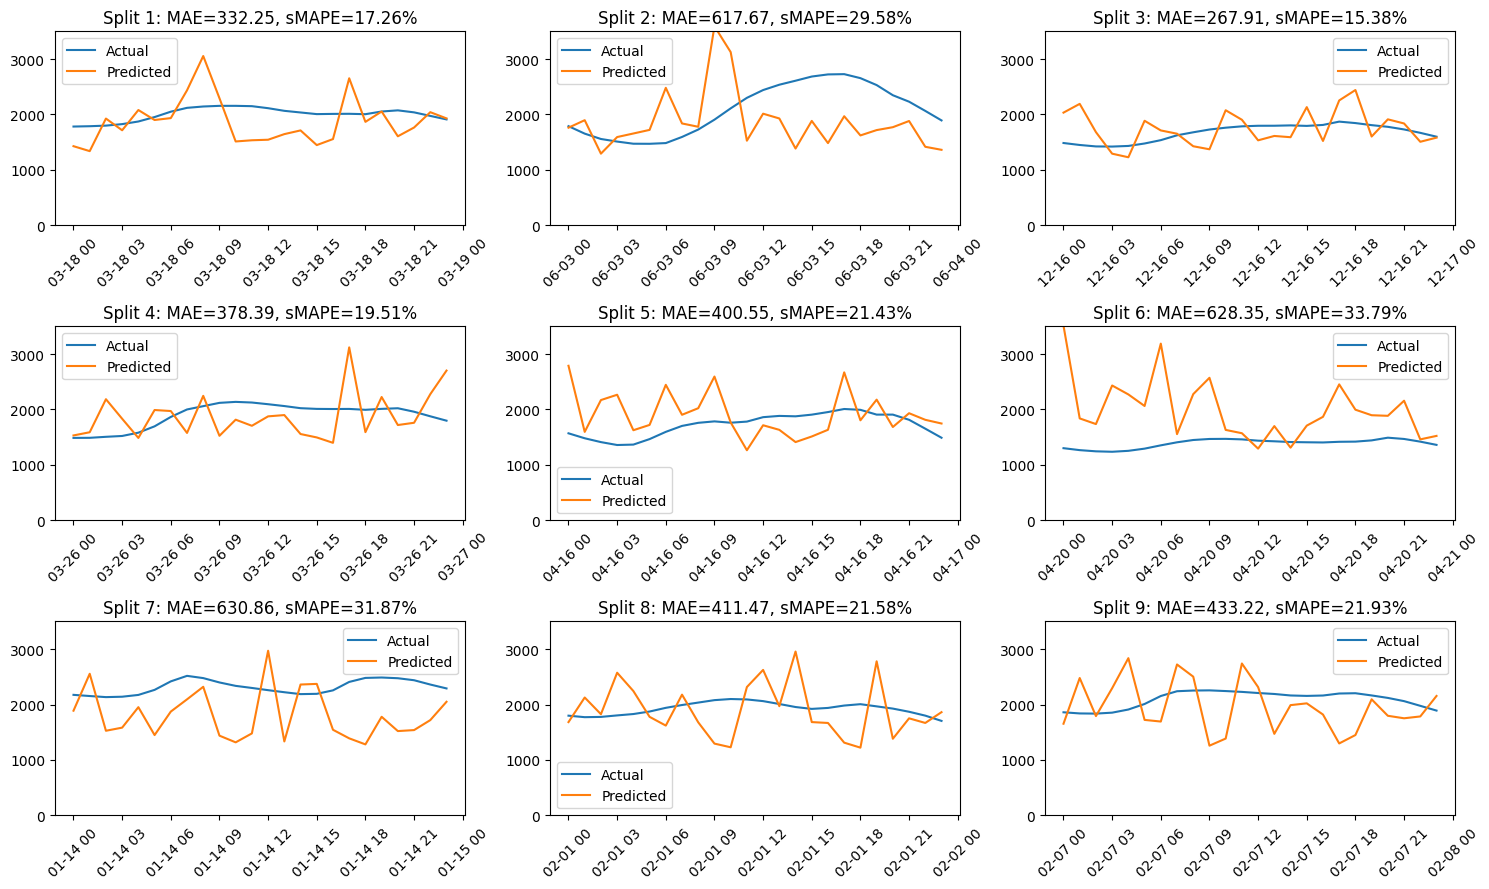

In [196]:
from sklearn.metrics import mean_absolute_error

n_rows = 3
evaluation_results = {"MAE": [], "sMAPE": []}
fig, axes = plt.subplots(n_rows, 3, figsize=(15, 3 * n_rows))
axes = axes.flatten()

# Define which columns are numeric and which are categorical
numeric_features = ["Kansas City International Airport Temperature (Fahrenheit)"]
# categorical_features = ["Weekday", "Weekend", "Season"]
# pass_through_features = ["Year", "Month", "Day", "Hour"]

# Build the preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        # ("cat", OneHotEncoder(drop="if_binary"), categorical_features),
        # ("passthrough", "passthrough", pass_through_features),
    ]
)

for i, (train_index, test_index) in enumerate(custom_splits):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

    # Create a pipeline with the preprocessor and a linear regression model
    model = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("regressor", BaselineModel()),
        ]
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    smape_value = smape(y_test, y_pred)

    evaluation_results["MAE"].append(mae)
    evaluation_results["sMAPE"].append(smape_value)

    axes[i].plot(y_test.index, y_test, label="Actual")
    axes[i].plot(y_test.index, y_pred, label="Predicted")
    axes[i].set_title(f"Split {i+1}: MAE={mae:.2f}, sMAPE={smape_value:.2f}%")
    axes[i].legend()
    axes[i].set_ylim(0, 3500)
    axes[i].tick_params(axis="x", rotation=45)

# Remove extra subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
pd.DataFrame(evaluation_results)

## Simple linear regression model based on temperature

,MAE,sMAPE
0,371.794832,20.274206
1,355.896942,17.388056
2,142.873498,8.590240
3,261.851396,14.318623
4,230.575261,13.211971
5,422.350192,26.536735
6,654.191461,32.758054
7,137.306947,7.236684
8,319.274124,16.265986


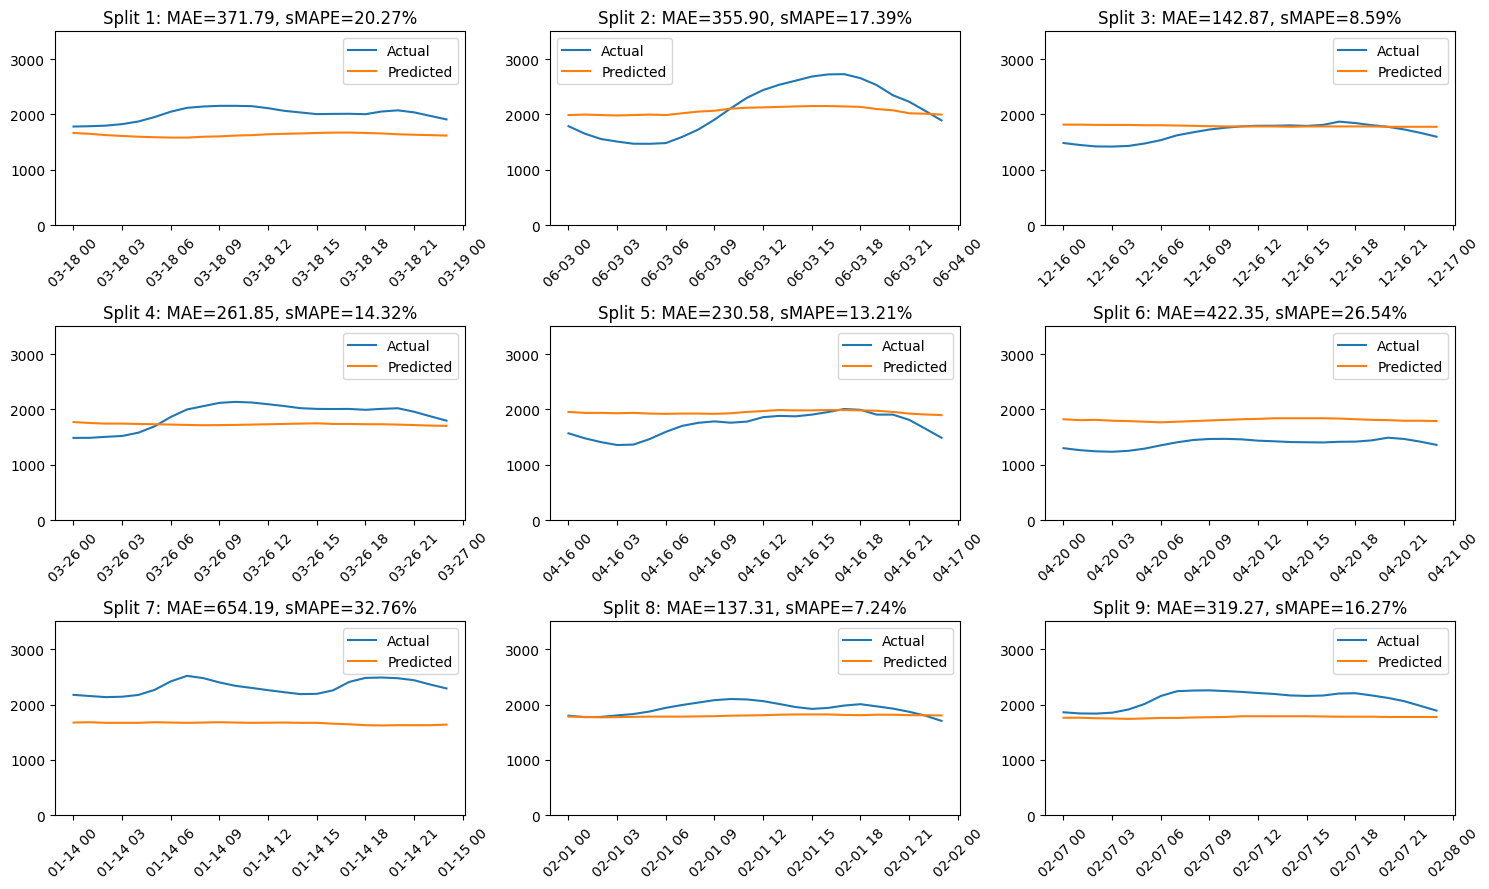

In [194]:
from sklearn.metrics import mean_absolute_error

n_rows = 3
evaluation_results = {"MAE": [], "sMAPE": []}
fig, axes = plt.subplots(n_rows, 3, figsize=(15, 3 * n_rows))
axes = axes.flatten()

# Define which columns are numeric and which are categorical
numeric_features = ["Kansas City International Airport Temperature (Fahrenheit)"]
# categorical_features = ["Weekday", "Weekend", "Season"]
# pass_through_features = ["Year", "Month", "Day", "Hour"]

# Build the preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        # ("cat", OneHotEncoder(drop="if_binary"), categorical_features),
        # ("passthrough", "passthrough", pass_through_features),
    ]
)

for i, (train_index, test_index) in enumerate(custom_splits):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

    # Create a pipeline with the preprocessor and a linear regression model
    model = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("regressor", LinearRegression()),
        ]
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    smape_value = smape(y_test, y_pred)

    evaluation_results["MAE"].append(mae)
    evaluation_results["sMAPE"].append(smape_value)

    axes[i].plot(y_test.index, y_test, label="Actual")
    axes[i].plot(y_test.index, y_pred, label="Predicted")
    axes[i].set_title(f"Split {i+1}: MAE={mae:.2f}, sMAPE={smape_value:.2f}%")
    axes[i].legend()
    axes[i].set_ylim(0, 3500)
    axes[i].tick_params(axis="x", rotation=45)

# Remove extra subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
pd.DataFrame(evaluation_results)

## WifeModel1

The WifeModel1 is based on my wife's intuition. She says our prediction should be the average of the same day of the week for the past month, and the same day of the week for the past month last year.

In [172]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, RegressorMixin


class WifeModel1(BaseEstimator, RegressorMixin):
    """
    Predicts future load as the average of:
    - The average load on the same day-of-week during the past month.
    - The average load on the same day-of-week during the past month of the previous year.
    """

    def __init__(self, fallback_value=None):
        self.fallback_value = fallback_value  # Default fallback if no historical data
        self.history_ = None

    def fit(self, X, y):
        self.history_ = pd.DataFrame({"y": y})
        self.history_.index = pd.to_datetime(X.index)
        return self

    def predict(self, X):
        preds = []
        # Determine the timestamps of X
        timestamps = pd.to_datetime(X.index)

        for t in timestamps:
            dow = t.weekday()  # day of week (0=Monday, ... 6=Sunday)

            # Current period: past 30 days before t matching day-of-week
            current_start = t - pd.Timedelta(days=30)
            current_mask = (
                (self.history_.index >= current_start)
                & (self.history_.index < t)
                & (self.history_.index.weekday == dow)
                & (self.history_.index.hour == t.hour)
            )
            current_data = self.history_[current_mask]

            # Previous year's period: past 30 days before (t - 1 year) matching day-of-week
            prev_year_date = t - pd.DateOffset(years=1)
            prev_start = prev_year_date - pd.Timedelta(days=30)
            prev_mask = (
                (self.history_.index >= prev_start)
                & (self.history_.index < prev_year_date)
                & (self.history_.index.weekday == dow)
                & (self.history_.index.hour == t.hour)
            )
            prev_data = self.history_[prev_mask]
            combined_data = pd.concat([current_data, prev_data])["y"]
            preds.append(combined_data.mean())

        return np.array(preds)

    def get_params(self, deep=True):
        """Required for compatibility with scikit-learn meta-estimators."""
        return {"fallback_value": self.fallback_value}

    def set_params(self, **params):
        """Required for compatibility with scikit-learn meta-estimators."""
        for key, value in params.items():
            setattr(self, key, value)
        return self

,MAE,sMAPE
0,226.309813,11.866455
1,425.005833,21.507405
2,95.989786,5.854967
3,189.947990,10.160105
4,89.042516,5.136210
5,98.613047,6.885233
6,292.437411,13.579185
7,315.622057,15.184098
8,142.452238,6.644528


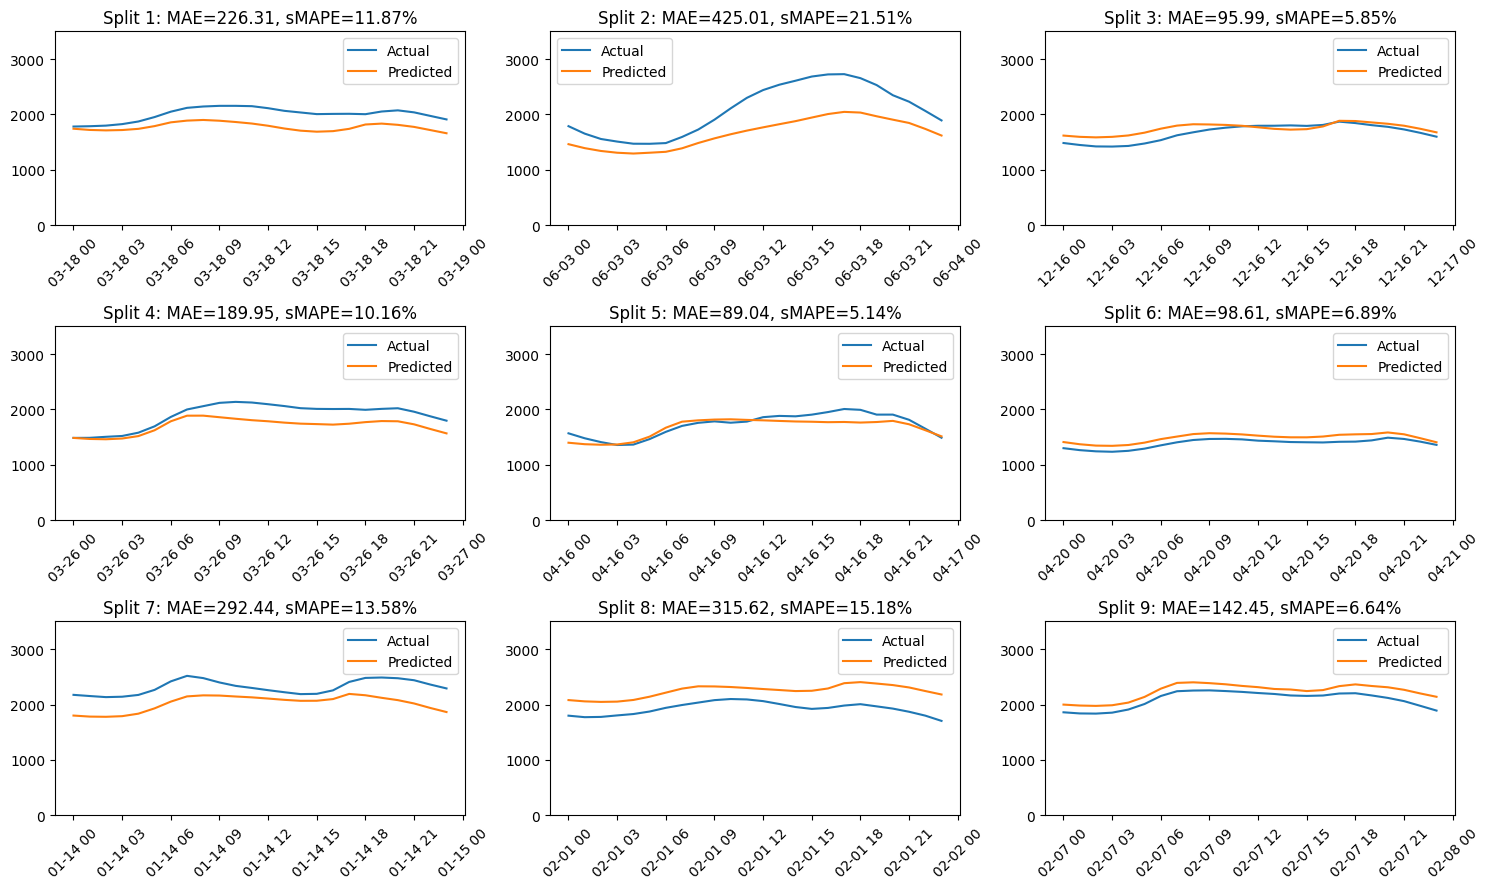

In [198]:
from sklearn.metrics import mean_absolute_error

n_rows = 3
evaluation_results = {"MAE": [], "sMAPE": []}
fig, axes = plt.subplots(n_rows, 3, figsize=(15, 3 * n_rows))
axes = axes.flatten()

for i, (train_index, test_index) in enumerate(custom_splits):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

    # Create a pipeline with the preprocessor and a linear regression model
    model = Pipeline(
        steps=[
            ("regressor", WifeModel1()),
        ]
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    smape_value = smape(y_test, y_pred)

    evaluation_results["MAE"].append(mae)
    evaluation_results["sMAPE"].append(smape_value)

    axes[i].plot(y_test.index, y_test, label="Actual")
    axes[i].plot(y_test.index, y_pred, label="Predicted")
    axes[i].set_title(f"Split {i+1}: MAE={mae:.2f}, sMAPE={smape_value:.2f}%")
    axes[i].legend()
    axes[i].set_ylim(0, 3500)
    axes[i].tick_params(axis="x", rotation=45)

# Remove extra subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
pd.DataFrame(evaluation_results)

## Random Forest Temperature Model

A random forest model using the temperature at MCI as the only feature. Hyperparameters are tuned using a random search.

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best hyperparameters: {'regressor__n_estimators': 50, 'regressor__min_samples_split': 10, 'regressor__min_samples_leaf': 4, 'regressor__max_depth': 10, 'regressor__bootstrap': False}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best hyperparameters: {'regressor__n_estimators': 50, 'regressor__min_samples_split': 10, 'regressor__min_samples_leaf': 4, 'regressor__max_depth': 10, 'regressor__bootstrap': False}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best hyperparameters: {'regressor__n_estimators': 50, 'regressor__min_samples_split': 10, 'regressor__min_samples_leaf': 4, 'regressor__max_depth': 10, 'regressor__bootstrap': False}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best hyperparameters: {'regressor__n_estimators': 50, 'regressor__min_samples_split': 10, 'regressor__min_samples_leaf': 2, 'regressor__max_depth': 10, 'regressor__bootstrap': True}
Fitting 3 folds for each 

,MAE,sMAPE
0,127.445126,6.272399
1,190.431924,9.356744
2,95.520427,5.875274
3,177.906243,9.658172
4,169.462811,9.742158
5,216.882965,14.571287
6,118.078937,5.180216
7,222.482485,12.090248
8,262.343127,13.123280


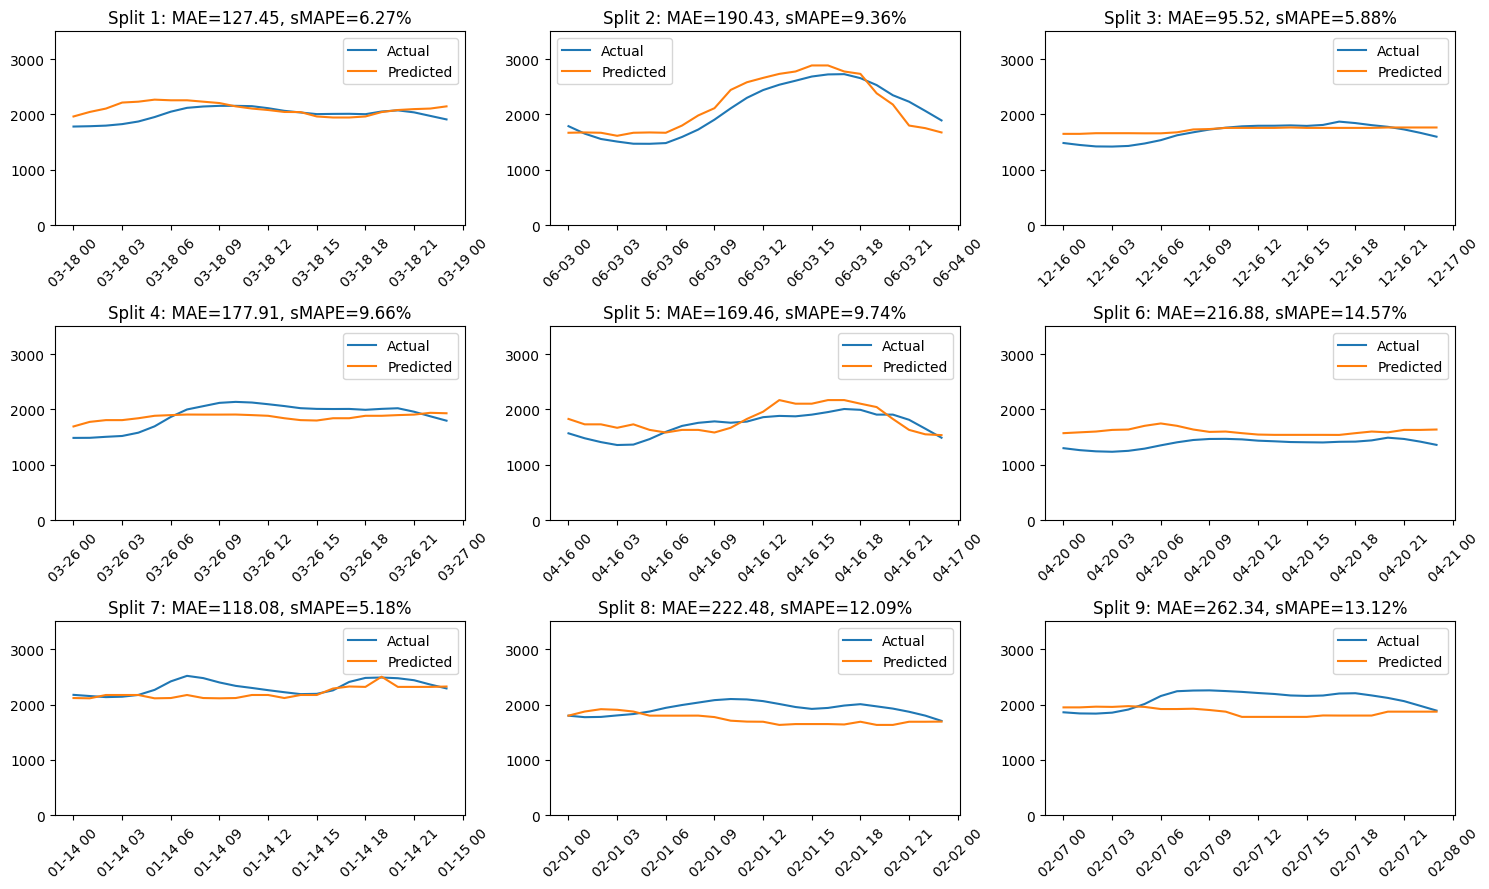

In [203]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV

n_rows = 3
evaluation_results = {"MAE": [], "sMAPE": []}
fig, axes = plt.subplots(n_rows, 3, figsize=(15, 3 * n_rows))
axes = axes.flatten()

# Define which columns are numeric and which are categorical
numeric_features = ["Kansas City International Airport Temperature (Fahrenheit)"]
# categorical_features = ["Weekday", "Weekend", "Season"]
# pass_through_features = ["Year", "Month", "Day", "Hour"]

# Build the preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        # ("cat", OneHotEncoder(drop="if_binary"), categorical_features),
        # ("passthrough", "passthrough", pass_through_features),
    ]
)

param_grid = {
    "regressor__n_estimators": [50, 100, 200, 300],
    "regressor__max_depth": [None, 10, 20, 30, 40],
    "regressor__min_samples_split": [2, 5, 10],
    "regressor__min_samples_leaf": [1, 2, 4],
    "regressor__bootstrap": [True, False],
}

for i, (train_index, test_index) in enumerate(custom_splits):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

    # Create a pipeline with the preprocessor and a linear regression model
    model = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("regressor", RandomForestRegressor()),
        ]
    )
    # Set up RandomizedSearchCV using the pipeline
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=10,  # Number of random parameter settings sampled
        cv=3,  # 3-fold cross-validation
        verbose=1,
        random_state=42,
        n_jobs=-1,  # Use all available CPU cores
    )

    # Run the random search on the training data
    random_search.fit(X_train, y_train)

    # Output the best hyperparameters found
    print("Best hyperparameters:", random_search.best_params_)

    # Evaluate the best model on the test set
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    smape_value = smape(y_test, y_pred)

    evaluation_results["MAE"].append(mae)
    evaluation_results["sMAPE"].append(smape_value)

    axes[i].plot(y_test.index, y_test, label="Actual")
    axes[i].plot(y_test.index, y_pred, label="Predicted")
    axes[i].set_title(f"Split {i+1}: MAE={mae:.2f}, sMAPE={smape_value:.2f}%")
    axes[i].legend()
    axes[i].set_ylim(0, 3500)
    axes[i].tick_params(axis="x", rotation=45)

# Remove extra subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
pd.DataFrame(evaluation_results)

## Random Forest Temperature Model + WifeModel1 (Ensemble Model)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best hyperparameters: {'regressor__n_estimators': 50, 'regressor__min_samples_split': 10, 'regressor__min_samples_leaf': 4, 'regressor__max_depth': 10, 'regressor__bootstrap': False}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best hyperparameters: {'regressor__n_estimators': 50, 'regressor__min_samples_split': 10, 'regressor__min_samples_leaf': 4, 'regressor__max_depth': 10, 'regressor__bootstrap': False}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best hyperparameters: {'regressor__n_estimators': 100, 'regressor__min_samples_split': 10, 'regressor__min_samples_leaf': 2, 'regressor__max_depth': 10, 'regressor__bootstrap': True}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best hyperparameters: {'regressor__n_estimators': 50, 'regressor__min_samples_split': 10, 'regressor__min_samples_leaf': 2, 'regressor__max_depth': 10, 'regressor__bootstrap': True}
Fitting 3 folds for each 

,Split,MAE,sMAPE
0,1,114.310677,5.809249
1,2,179.780268,8.354881
2,3,90.167949,5.565515
3,4,164.229447,8.797705
4,5,66.313847,4.039790
5,6,157.268193,10.842665
6,7,198.001202,8.889381
7,8,92.899671,4.839328
8,9,106.533624,5.155258


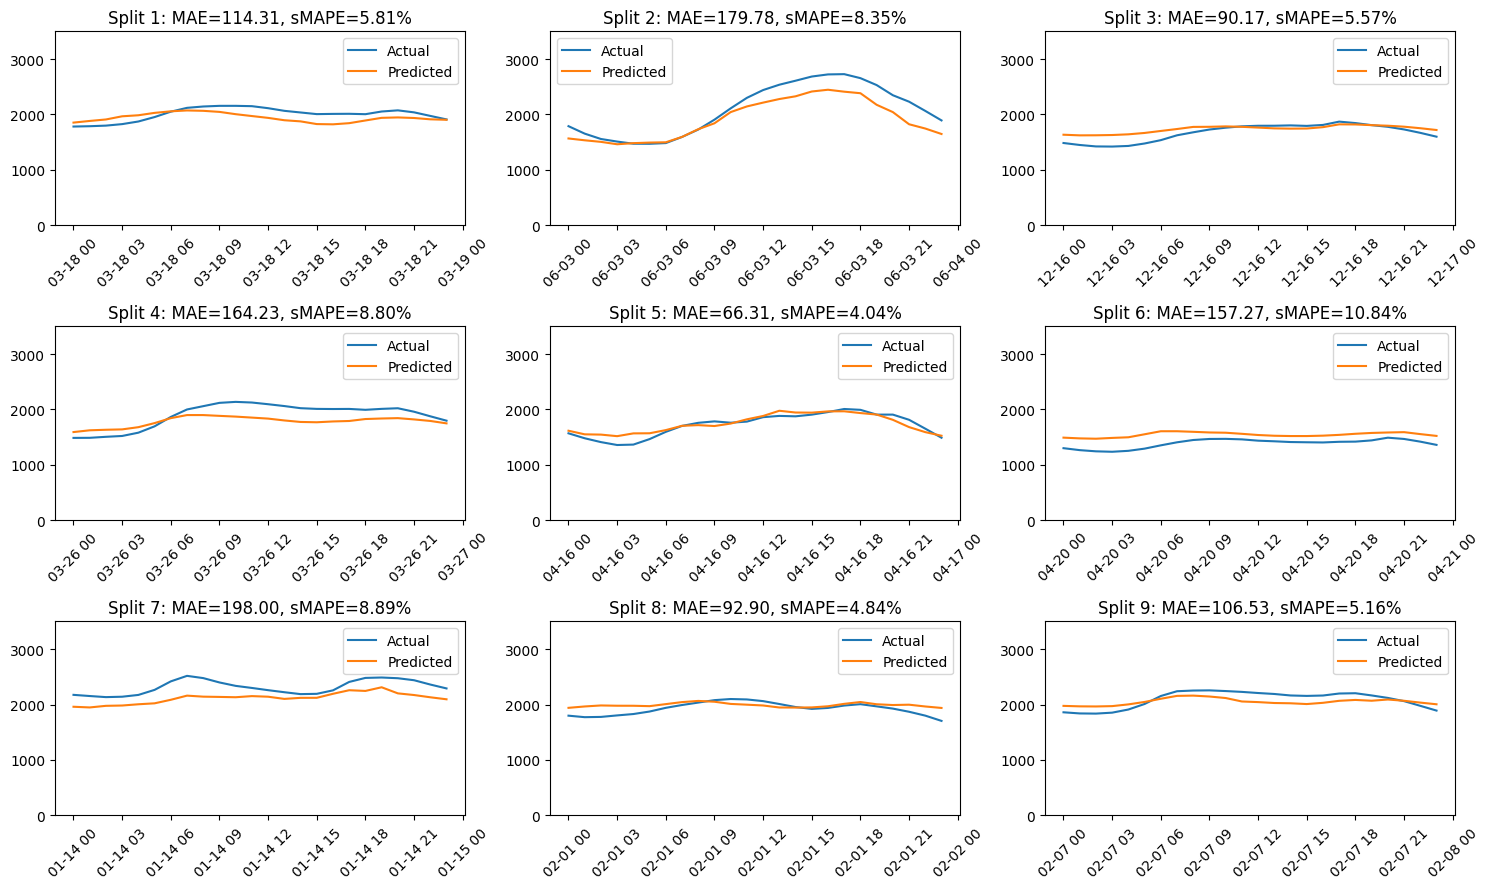

In [211]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV

n_rows = 3
evaluation_results = {"Split": [], "MAE": [], "sMAPE": []}
fig, axes = plt.subplots(n_rows, 3, figsize=(15, 3 * n_rows))
axes = axes.flatten()

# Define which columns are numeric and which are categorical
numeric_features = ["Kansas City International Airport Temperature (Fahrenheit)"]
# categorical_features = ["Weekday", "Weekend", "Season"]
# pass_through_features = ["Year", "Month", "Day", "Hour"]

# Build the preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        # ("cat", OneHotEncoder(drop="if_binary"), categorical_features),
        # ("passthrough", "passthrough", pass_through_features),
    ]
)

param_grid = {
    "regressor__n_estimators": [50, 100, 200, 300],
    "regressor__max_depth": [None, 10, 20, 30, 40],
    "regressor__min_samples_split": [2, 5, 10],
    "regressor__min_samples_leaf": [1, 2, 4],
    "regressor__bootstrap": [True, False],
}

for i, (train_index, test_index) in enumerate(custom_splits):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

    # Create a pipeline with the preprocessor and a linear regression model
    rf_model = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("regressor", RandomForestRegressor()),
        ]
    )

    # Set up RandomizedSearchCV using the pipeline
    random_search = RandomizedSearchCV(
        estimator=rf_model,
        param_distributions=param_grid,
        n_iter=10,  # Number of random parameter settings sampled
        cv=3,  # 3-fold cross-validation
        verbose=1,
        random_state=42,
        n_jobs=-1,  # Use all available CPU cores
    )

    # Run the random search on the training data
    random_search.fit(X_train, y_train)

    # Output the best hyperparameters found
    print("Best hyperparameters:", random_search.best_params_)

    # Evaluate the best model on the test set
    best_model = random_search.best_estimator_
    y_pred_rf = best_model.predict(X_test)

    # Wife model
    wife_model = WifeModel1()
    wife_model.fit(X_train, y_train)
    y_pred_wife = wife_model.predict(X_test)

    # Combine the predictions and apply weights
    weights = [0.5, 0.5]
    y_pred = weights[0] * y_pred_rf + weights[1] * y_pred_wife

    mae = mean_absolute_error(y_test, y_pred)
    smape_value = smape(y_test, y_pred)

    evaluation_results["Split"].append(i + 1)
    evaluation_results["MAE"].append(mae)
    evaluation_results["sMAPE"].append(smape_value)

    axes[i].plot(y_test.index, y_test, label="Actual")
    axes[i].plot(y_test.index, y_pred, label="Predicted")
    axes[i].set_title(f"Split {i+1}: MAE={mae:.2f}, sMAPE={smape_value:.2f}%")
    axes[i].legend()
    axes[i].set_ylim(0, 3500)
    axes[i].tick_params(axis="x", rotation=45)

# Remove extra subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
pd.DataFrame(evaluation_results)